In [28]:
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
from tensorflow import keras
import random as rand
import cv2
import pandas as pd
np.set_printoptions(suppress=True)

x_digit = idx2numpy.convert_from_file('data/train-images-idx3-ubyte')
y_digit = idx2numpy.convert_from_file('data/train-labels-idx1-ubyte')

print(x_digit.shape, y_digit.shape)
BATCH_SIZE = 4
TRAIN_SIZE = 128
TEST_SIZE = 5000
EPOCHS = 300
OUTER_IMG_SZ = 152

(60000, 28, 28) (60000,)


In [4]:
### Generate train and test data using mnist set with NUM_SIZE digits
GRID_SIDE = 9

image_dict = [[] for i in range(10)]
for digit,image in zip(y_digit, x_digit):
    image_dict[digit].append(image)

In [5]:
def normalize(arr):
    mn = np.amin(arr) 
    mx = np.amax(arr) 
    return (arr - mn)/(mx - mn)

In [6]:
def arr_stats(arr):
    mn = np.amin(arr) 
    mx = np.amax(arr) 
    rng = np.ptp(arr) 
    varience = np.var(arr) 
    sd = np.std(arr) 
    print("Measures of Dispersion") 
    print("Minimum =", mn) 
    print("Maximum =", mx) 
    print("Range =", rng) 
    print("Varience =", varience) 
    print("Standard Deviation =", sd) 
    print(arr)
    plt.imshow(arr)

In [7]:
class SudokuPuzzleGenerator(keras.utils.Sequence):
    
    def __init__(self, length_of_set, batch_size=BATCH_SIZE):
        self.batch_size = batch_size
        self.length_of_set = length_of_set
        self.epoch_count = 0.0
    
    def __len__(self):
        'Denotes the number of batches per epoch 10k/128'
        ret = self.length_of_set // self.batch_size
        #print("Returning length as " + str(ret))
        return ret

    def __getitem__(self, index):
        'Generate one batch of data'
        #print("Getting item for index " + str(index))
        # Generate indexes of the batch
        #print("using batch_size " + str(self.batch_size))
        x, y = self.gen_test_data(self.batch_size)
        #print("Shapes of returned ", x.shape, y.shape)
        return x, y
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.epoch_count += 1.0
        #print("An epoch ended >>>>>>> xxxxxxx >>>>>> qqq >>>>")
    
    
    def warp_image(self, img, offsets, puzzle_size):
        top = offsets[0]
        left = offsets[1]
        bottom = offsets[2]
        right = offsets[3]
        
        top_left = [left, top]
        bottom_left = [left, bottom]
        top_right = [right, top]
        bottom_right = [right, bottom]
        
        #print("\nInput offsets: " + str(offsets))
              
        initial_pts = np.float32([top_left, bottom_left, top_right, bottom_right])
        
        #print("\nInput points: " + str(initial_pts))

    
        #translate each offset by upto 30% of the puzzle_size taking care not to go out of OUTER_IMG_SZ
        
        puzzle_size_percent = int(puzzle_size * 0.05)
        
        max_trans_top = min(top, puzzle_size_percent)
        
        max_trans_left = min(left, puzzle_size_percent)
        
        max_trans_bottom = min(OUTER_IMG_SZ - bottom, puzzle_size_percent)
        
        max_trans_right = min(OUTER_IMG_SZ - right, puzzle_size_percent)
        
        top_left = [left + rand.randint(-max_trans_left, max_trans_left), top + rand.randint(-max_trans_top, max_trans_top)]
        bottom_left = [left + rand.randint(-max_trans_left, max_trans_left), bottom + rand.randint(-max_trans_bottom, max_trans_bottom)]
        top_right = [right + rand.randint(-max_trans_right, max_trans_right), top + rand.randint(-max_trans_top, max_trans_top)]
        bottom_right = [right + rand.randint(-max_trans_right, max_trans_right), bottom + rand.randint(-max_trans_bottom, max_trans_bottom)]
        
        dest_pts = np.float32([top_left, bottom_left, top_right, bottom_right])
        
        warp_matrix = cv2.getPerspectiveTransform(initial_pts, dest_pts)
        warped_img = cv2.warpPerspective(img, warp_matrix, (OUTER_IMG_SZ, OUTER_IMG_SZ), borderMode = cv2.BORDER_REFLECT_101 )
        
        warped_offsets = [top, left, bottom,right]
                
        #print("\nwarped offsets: " + str(warped_offsets))
        #print("\nwarped points: " + str(dest_pts))
        #print("\nwarped points2: " , dest_pts.reshape((8)).shape)

        
        return warped_img, dest_pts.reshape(8)

    def get_from_bg(self):
        rnd = rand.randint(1,9)
        fn = "backgrounds/" + str(rnd) + ".jpeg"
        #print(fn)
        img = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (OUTER_IMG_SZ,OUTER_IMG_SZ))
        #img = normalize(img)
        return img
    
    def gen_test_data(self, num_data):
        x_data, y_data = np.zeros((num_data, OUTER_IMG_SZ , OUTER_IMG_SZ)), np.zeros((num_data, 8))
        #x_data, y_data = 100 * np.random.randn(num_data, OUTER_IMG_SZ , OUTER_IMG_SZ), np.zeros((num_data, 8))
        for i in range(num_data):
            x_data[i] = self.get_from_bg()
            #pick a random size so that the grid is at least 50% of the overall image
            border_sz = rand.randint(1,2)
            digit_sz = rand.randint(OUTER_IMG_SZ//(1.4 * GRID_SIDE), OUTER_IMG_SZ//GRID_SIDE) - 2 * border_sz
            border_digit_sz  = digit_sz + 2 * border_sz
            grid_size = GRID_SIDE * (border_digit_sz)
            #pick random offsets so image doesn't go off screen
            x_offset = rand.randint(0, OUTER_IMG_SZ - grid_size)
            y_offset = rand.randint(0, OUTER_IMG_SZ - grid_size)
            offsets = [y_offset, x_offset, y_offset + grid_size, x_offset + grid_size]
            #x_data[i] = np.random.randint(0, 255, size = ((OUTER_IMG_SZ , OUTER_IMG_SZ)))
            clr = list(np.random.choice(range(256), size=3))
            clr = [255,255,255]
            for k in range(GRID_SIDE**2):
                #rand_digit = rand.randint(0,9)
                #rand_img = rand.choice(image_dict[rand_digit])
                rand_img = np.zeros((digit_sz, digit_sz))
                #rand_img = cv2.resize(rand_img, (digit_sz, digit_sz))
                #if rand_digit == 0 : rand_img = np.zeros((digit_sz, digit_sz))
                rand_img = cv2.copyMakeBorder(rand_img, border_sz,border_sz,border_sz,border_sz, cv2.BORDER_CONSTANT, value = [int(clr[0]),int(clr[1]),int(clr[2])])
                r = k//GRID_SIDE
                c = k % GRID_SIDE
                x_data[i, y_offset + r*border_digit_sz:y_offset + (r+1)*border_digit_sz, x_offset + border_digit_sz*c:x_offset + border_digit_sz*(c+1)] += rand_img
                
            x_data[i], y_data[i] = self.warp_image(x_data[i], offsets, grid_size)
        x_data = normalize(x_data)
        return x_data, y_data
    

In [10]:
def visualize(img, coords):
   
    circle1 = plt.Circle((coords[0],coords[1]) , 5, color='r')
    circle2 = plt.Circle((coords[2],coords[3]) , 5, color='r')
    circle3 = plt.Circle((coords[4],coords[5]) , 5, color='r')
    circle4 = plt.Circle((coords[6],coords[7]) , 5, color='r')
    
    
    plt.gca().add_patch(circle1)
    plt.gca().add_patch(circle2)
    plt.gca().add_patch(circle3)
    plt.gca().add_patch(circle4)
    
        
    plt.imshow(img)
    plt.show()

(152, 152)


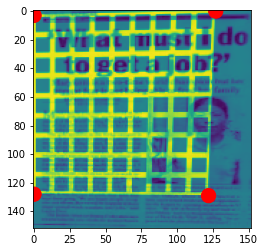

Measures of Dispersion
Minimum = 0.010208831671963639
Maximum = 0.9926559482934324
Range = 0.9824471166214688
Varience = 0.06017498521659575
Standard Deviation = 0.24530590130813354
[[0.44772176 0.44772176 0.44772176 ... 0.42839827 0.43097271 0.44177437]
 [0.44780476 0.44783132 0.44784626 ... 0.42352618 0.42761697 0.4396462 ]
 [0.45526957 0.45954407 0.46194847 ... 0.39571969 0.40700528 0.42452553]
 ...
 [0.36329616 0.36508844 0.36642733 ... 0.41763615 0.41933922 0.40967885]
 [0.41704287 0.4197467  0.42329092 ... 0.42196053 0.42146242 0.41747344]
 [0.40077488 0.40464735 0.40933345 ... 0.42059433 0.41777173 0.41795848]]


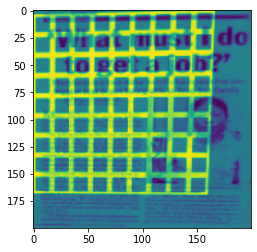

In [20]:
gen = SudokuPuzzleGenerator(1)
x,y = gen.gen_test_data(1)
print(x[0].shape)
visualize(x[0], y[0])
plt.show()
arr_stats(cv2.resize(x[0],(200,200)))
#print(x)

In [21]:
act = 'relu'
pad = 'same'
strd = 1
filter_size_mul = 7
krnl_sz = 7
input_layer = tf.keras.Input(shape = (OUTER_IMG_SZ, OUTER_IMG_SZ,1))

branch_1 = tf.keras.layers.Conv2D(filters = 5, kernel_size=(OUTER_IMG_SZ//2, 30), activation = act, padding = 'valid', strides = (OUTER_IMG_SZ//2 ,int(30)))(input_layer)
branch_1 = tf.keras.layers.Flatten()(branch_1)

branch_2 = tf.keras.layers.Conv2D(filters = 5, kernel_size=(30, OUTER_IMG_SZ//2), activation = act, padding = 'valid', strides = (30, OUTER_IMG_SZ//2))(input_layer)
branch_2 = tf.keras.layers.Flatten()(branch_2)

branch_3 = tf.keras.layers.Conv2D(filters = 5, kernel_size=(OUTER_IMG_SZ, 30), activation = act, padding = 'valid', strides = 10)(input_layer)
branch_3 = tf.keras.layers.Flatten()(branch_3)

branch_4 = tf.keras.layers.Conv2D(filters = 5, kernel_size=(30, OUTER_IMG_SZ), activation = act, padding = 'valid', strides = 10)(input_layer)
branch_4 = tf.keras.layers.Flatten()(branch_4)

branch_5 = tf.keras.layers.Conv2D(filters = 5, kernel_size=(OUTER_IMG_SZ//2, OUTER_IMG_SZ//2), activation = act, padding = 'valid', strides = 10)(input_layer)
branch_5 = tf.keras.layers.Flatten()(branch_5)

common = tf.keras.layers.concatenate([branch_1, branch_2, branch_3, branch_4, branch_5], axis=-1)


#_ = tf.keras.layers.MaxPool2D()(_)
# = tf.keras.layers.Conv2D(filters=filter_size_mul*4, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 
# = tf.keras.layers.Conv2D(filters=filter_size_mul*4, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 
# = tf.keras.layers.MaxPool2D()(_)
# = tf.keras.layers.Conv2D(filters=filter_size_mul*8, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 
# = tf.keras.layers.Conv2D(filters=filter_size_mul*8, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 

'''
_ = tf.keras.layers.AveragePooling2D()(_) 
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*5, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*5, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.AveragePooling2D()(_) 
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*6, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*6, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 

_ = tf.keras.layers.MaxPool2D()(_) 
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*16, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*16, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_)
_ = tf.keras.layers.MaxPool2D()(_) 
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*32, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*32, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_)
_ = tf.keras.layers.MaxPool2D()(_)
'''

_ = tf.keras.layers.Flatten()(common)
_ = tf.keras.layers.Dense(308, activation=act)(_)
_ = tf.keras.layers.Dense(308, activation=act)(_)
_ = tf.keras.layers.Dense(150, activation=act)(_)
_ = tf.keras.layers.Dense(50, activation=act)(_)
_ = tf.keras.layers.Dense(16, activation=act)(_)
output_layers = tf.keras.layers.Dense(8, name="edges")(_)



def distance_between_pts_loss(y_true, y_pred):
    dists = []
    for i in range(0, 4):
        true_px = y_true[:, i * 2:i * 2 + 1]
        pred_px = y_pred[:, i * 2:i * 2 + 1]
        true_py = y_true[:, i * 2 + 1:i * 2 + 2]
        pred_py = y_pred[:, i * 2 + 1:i * 2 + 2]
        dist = tf.math.sqrt(tf.math.square(tf.math.subtract(true_px,pred_px)) + tf.math.square(tf.math.subtract(true_py, pred_py)))
        
        '''
        p2 = tf.cond(tf.math.greater(pred_px, OUTER_IMG_SZ), lambda: tf.math.add(dist, 1000.0, lambda: 0.0)
        p1 = tf.cond(tf.math.less(pred_px , true_px), lambda: 100.0, lambda: 0.0)

        p3 = tf.cond(tf.math.greater(pred_py, OUTER_IMG_SZ), lambda: 1000.0, lambda: 0.0)
        p4 = tf.cond(tf.math.less(pred_py , true_py), lambda: 100.0, lambda: 0.0)
        
        xp = tf.math.add(p1,p2)
        yp = tf.math.add(p3,p4)
        tp = tf.math.add(xp,yp)
        '''
        '''
        v1 = tf.cast(tf.math.greater(pred_px, OUTER_IMG_SZ), tf.float32)
        p1 = tf.math.scalar_mul(OUTER_IMG_SZ//3, v1)

        v2 = tf.cast(tf.math.less(pred_px , true_px), tf.float32)
        p2 = tf.math.scalar_mul(30, v2)
        
        v3 = tf.cast(tf.math.greater(pred_py, OUTER_IMG_SZ), tf.float32)
        p3 = tf.math.scalar_mul(OUTER_IMG_SZ//3, v3)
        
        v4 = tf.cast(tf.math.less(pred_py , true_py), tf.float32)
        p4 = tf.math.scalar_mul(30, v4)
        
        xp = tf.math.add(p1, p2)
        yp = tf.math.add(p3,p4)
        tp = tf.math.add(xp,yp)
        '''
        

        
        dists.append(tf.math.square(dist))
        
    return tf.math.reduce_sum(dists)
    '''
    print(y_true)
    print("\n---")
    print(y_pred)
    return tf.math.reduce_mean(tf.math.subtract(y_true, y_pred))
    '''

loss_fns = tf.keras.losses.MeanSquaredError()

model = tf.keras.Model(inputs=input_layer, outputs = output_layers, name="digit_recognizer")
#model.compile(optimizer=tf.keras.optimi`zers.SGD(learning_rate=0.02, momentum=0.2),
#             loss = distance_between_pts_loss,
#             metrics = ['accuracy'] )
#model.summary()

#model = keras.models.load_model('models/grid_detector_with_noise')


In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss = distance_between_pts_loss,
             metrics = ['accuracy'] )
model.summary()

Model: "digit_recognizer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 152, 152, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 2, 5, 5)      11405       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 5, 2, 5)      11405       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 1, 13, 5)     22805       input_1[0][0]                    
___________________________________________________________________________________

In [23]:
training_gen = SudokuPuzzleGenerator(TRAIN_SIZE)
validation_gen = SudokuPuzzleGenerator(TEST_SIZE)

In [29]:
model.fit(x = training_gen, y=None, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/300
 1/10 [==>...........................] - ETA: 5:07 - loss: 8456662.0000 - accuracy: 0.1895

KeyboardInterrupt: 

In [167]:
model.evaluate(x=validation_gen, y=None, verbose=1)

312/312 [==============================] - 5s 17ms/step - loss: 8879.4844 - accuracy: 0.3738


[8879.484375, 0.37379807233810425]

In [168]:
model.save('models/grid_detector_custom_bg_if_else_loss_sum_square_dist')


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: models/grid_detector_custom_bg_if_else_loss_sum_square_dist/assets


In [1]:
x,y = training_gen.gen_test_data(1)
#_, x = cv2.threshold(x, 127, 255, cv2.THRESH_BINARY)
print(x.shape, y.shape)
plt.imshow(x[0])
plt.show()
print(y)
pred  = model.predict(x)
print(pred)
visualize(x[0], pred[0])
matplotlib.image.imsave('saved.png', x[0])

NameError: name 'training_gen' is not defined

In [154]:
dgen = tf.keras.preprocessing.image.ImageDataGenerator()
tst_img = dgen.apply_transform(x.reshape(512,512,1) , {'shear':5, 'theta' : -25})
plt.imshow(tst_img.reshape(512,512))
model.predict(tst_img.reshape(1,512,512))

ValueError: cannot reshape array of size 23104 into shape (512,512,1)

In [1]:
visualize(tst_img, model.predict(tst_img.reshape(1,512,512))[0])

NameError: name 'visualize' is not defined

(506, 760)


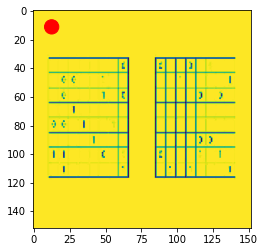

[ 12.314459  11.036909  12.918578 329.53876  336.92108    5.220883
 339.36502  327.78806 ]


0

In [196]:
def from_img():
    img = cv2.imread('6.jpeg', cv2.IMREAD_GRAYSCALE)
    print(img.shape)
    img = cv2.resize(img, (OUTER_IMG_SZ,OUTER_IMG_SZ))
    img = normalize(img)
    visualize(img, model.predict(img.reshape(1,OUTER_IMG_SZ,OUTER_IMG_SZ))[0])
    print(model.predict(img.reshape(1,OUTER_IMG_SZ,OUTER_IMG_SZ))[0])
    #arr_stats(cv2.resize(img, (200,200)))
    return 0
from_img()